# Expected Improvement BO


In [1]:
# Import the class
import torch
import yaml

## Customizing the UpperConfidenceBound Generator
First lets examine the possible options that we can specify for the
UpperConfidenceBound generator. We can use these keys to customize optimization.

In [2]:
from xopt.utils import get_generator_and_defaults
ei_gen, ei_options = get_generator_and_defaults("expected_improvement")
print(yaml.dump(ei_options.dict()))

acq:
  monte_carlo_samples: 128
  proximal_lengthscales: null
  use_transformed_proximal_weights: true
model:
  use_conservative_prior_lengthscale: false
  use_conservative_prior_mean: false
  use_low_noise_prior: false
n_initial: 3
optim:
  max_travel_distances: null
  num_restarts: 5
  raw_samples: 20
  sequential: true
  use_nearby_initial_points: true



In [3]:
from xopt.resources.test_functions.rosenbrock import make_rosenbrock_vocs, evaluate_rosenbrock
from xopt import Xopt, Evaluator
import pandas as pd

vocs = make_rosenbrock_vocs(2)

generator_options = ei_gen.default_options()
generator_options.optim.num_restarts = 20
generator_options.optim.max_travel_distances = [0.1, 0.1]
generator_options.model.use_low_noise_prior = True
#generator_options.acq.proximal_lengthscales = [0.01, 0.01]

evaluator = Evaluator(function=evaluate_rosenbrock)
generator = ei_gen(vocs, generator_options)


/tmp/ipykernel_2651/1777906059.py:13: DeprecationWarning: `copy_on_model_validation` should be a string: 'deep', 'shallow' or 'none'
  evaluator = Evaluator(function=evaluate_rosenbrock)


In [4]:
X = Xopt(generator=generator, evaluator=evaluator, vocs=vocs)

for i in range(100):
    X.step()
    print(f"step {i}: best: {X.data['y'].min()}")


step 0: best: 10.025799015259972
step 1: best: 10.025799015259972
step 2: best: 10.025799015259972
step 3: best: 10.025799015259972
step 4: best: 10.025799015259972
step 5: best: 10.025799015259972
step 6: best: 10.025799015259972
step 7: best: 10.025799015259972
step 8: best: 10.025799015259972
step 9: best: 10.025799015259972
step 10: best: 10.025799015259972
step 11: best: 10.025799015259972
step 12: best: 10.025799015259972
step 13: best: 10.025799015259972
step 14: best: 10.025799015259972
step 15: best: 10.025799015259972
step 16: best: 10.025799015259972
step 17: best: 10.025799015259972
step 18: best: 10.025799015259972
step 19: best: 10.025799015259972
step 20: best: 10.025799015259972
step 21: best: 10.025799015259972
step 22: best: 10.025799015259972
step 23: best: 10.025799015259972
step 24: best: 10.025799015259972
step 25: best: 10.025799015259972
step 26: best: 10.025799015259972
step 27: best: 10.025799015259972
step 28: best: 10.025799015259972
step 29: best: 10.025799

## View output data

In [5]:
X.data

,x0,x1,y,xopt_error,xopt_error_str
1,0.282820,0.649263,32.921816,False,
2,-0.262724,0.359391,10.025799,False,
3,1.280116,-0.690438,542.565699,False,
4,1.474651,-0.617362,779.727557,False,
5,1.173761,-0.768528,460.666035,False,
...,...,...,...,...,...
98,-0.723727,-1.967008,623.374012,False,
99,-0.914561,-1.769974,682.994788,False,
100,-1.181111,-1.373317,771.128043,False,
101,-1.320537,-1.401375,994.608177,False,


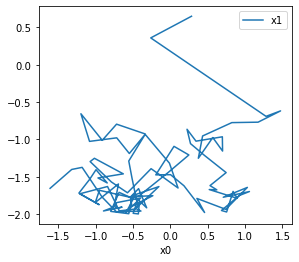

In [6]:
# plot results
ax = X.data.plot(*vocs.variable_names)
ax.set_aspect("equal")

## Visualize model used by upper confidence bound
Models are kept in a list, in this case that list has one element, the model
created for the objective `y1`.


/usr/share/miniconda/envs/xopt-dev/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1660136119739/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


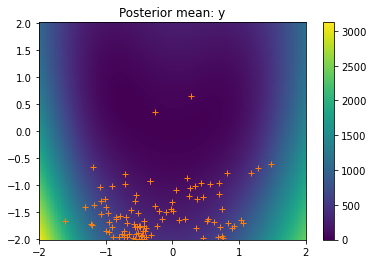

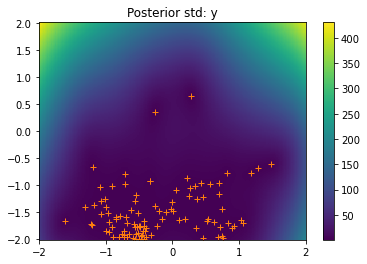

In [7]:
from matplotlib import pyplot as plt  # plot model predictions

data = X.data

bounds = generator.vocs.bounds
model = generator.train_model(generator.data)

# create mesh
n = 200
x = torch.linspace(*bounds.T[0], n)
y = torch.linspace(*bounds.T[1], n)
xx, yy = torch.meshgrid(x, y)
pts = torch.hstack([ele.reshape(-1, 1) for ele in (xx, yy)]).double()

outputs = generator.vocs.output_names
with torch.no_grad():
    post = model.posterior(pts)

    mean = post.mean
    std = torch.sqrt(post.variance)

    fig, ax = plt.subplots()
    ax.plot(*data[vocs.variable_names].to_numpy().T, "+C1")
    c = ax.pcolor(xx, yy, mean.reshape(n, n))
    fig.colorbar(c)
    ax.set_title(f"Posterior mean: {outputs[0]}")

    fig2, ax2 = plt.subplots()
    ax2.plot(*data[vocs.variable_names].to_numpy().T, "+C1")
    c = ax2.pcolor(xx, yy, std.reshape(n, n))
    fig2.colorbar(c)
    ax2.set_title(f"Posterior std: {outputs[0]}")

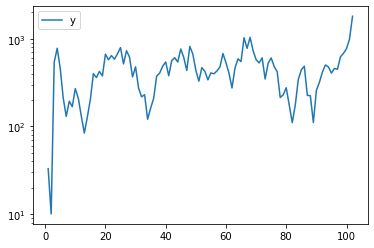

In [8]:
ax = X.data.plot(y="y", logy=True)

In [9]:
# Cleanup
!rm dump.yaml

rm: cannot remove 'dump.yaml': No such file or directory
